In [1]:
#import libraries 

import pandas as pd
import numpy as np
from scipy.optimize import minimize
from joblib import Parallel, delayed
from scipy.stats import mode
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import seaborn as sns
from itertools import product

In [2]:
#retreive NP-separated isotope data
fn = '../data/20250121_kkeller_gc_irms_data_corrected.xlsx'
df = pd.read_excel(fn, sheet_name='NP_separated_iso')

#split dataframe into sample and gdgt
def split_sample_id(df):
    df[['sample', 'GDGT']] = df['sample_id'].str.split('_', expand=True)
    return df
df = split_sample_id(df)

#remove outlier samples
df= df.loc[(df['GDGT'] != 'Cren') | (df['biphytane'] != 'BP-0')] #BP-0 in Cren samples from iGDGT-4 co-elution/contamination
df = df.loc[(df['GDGT'] != 'G3') | (df['biphytane'] != 'BP-0')] #BP-0 in iGDGT-3 samples from iGDGT-4 co-elution/contamination
# df = df.loc[(df['sample'] != 'S7') | (df['GDGT'] != 'G0')] #sample S7 contaminated sample
# df = df.loc[(df['sample'] != 'S7') | (df['GDGT'] != 'G2')]  #sample S7 contaminated sample
# df = df.loc[(df['sample'] != 'S7') | (df['biphytane'] != 'BP-1')]  #sample S7 contaminated sample
df = df[df['sample'] != 'S7']
condition = ~((df['sample_id'] == 'S1_G2') & (df['biphytane'] == 'BP-0'))
# df = df[condition]
df = df.dropna() #drop any NaNs

#evaluate new df
df

,sample_id,biphytane,distance_from_plume,corrected_d2H.permil,corrected_d2H_sem.permil,d13C,sample,GDGT
2,S1_Cren,BP-2,20,-302.365450,4.828766,-22.70,S1,Cren
3,S1_Cren,BP-3 (Cren),20,-283.796786,5.220387,-22.70,S1,Cren
4,S1_G0,BP-0,20,-302.067513,5.766330,-30.91,S1,G0
6,S1_G2,BP-0,20,-198.549425,5.766330,-83.71,S1,G2
7,S1_G2,BP-1,20,-215.105567,5.518425,-83.71,S1,G2
11,S10_Cren,BP-2,0,-286.394448,4.440020,-31.55,S10,Cren
12,S10_Cren,BP-3 (Cren),0,-304.549891,4.750350,-31.55,S10,Cren
13,S10_G0,BP-0,0,-314.531671,3.959855,-35.05,S10,G0
14,S10_G1,BP-0,0,-263.098011,4.096167,-78.34,S10,G1
15,S10_G1,BP-1,0,-233.621481,4.064346,-78.34,S10,G1


In [3]:
#retrieve relative abundance data
fn2 = '../data/Keller_GC_FID.xlsx'
df_rel_abund = pd.read_excel(fn2)
df_rel_abund


,sample_id,GDGT,distance,biphytane,rel_abundance
0,S1_Cren,Cren,20,BP-0,0.022269
1,S1_Cren,Cren,20,BP-2,0.505841
2,S1_Cren,Cren,20,BP-3 (Cren),0.471890
3,S1_G0,G0,20,BP-0,1.000000
4,S1_G2,G2,20,BP-0,0.283976
...,...,...,...,...,...
58,S9_G2,G2,0,BP-2,0.248889
59,S9_G3,G3,0,BP-0,0.090233
60,S9_G3,G3,0,BP-1,0.363982
61,S9_G3,G3,0,BP-2,0.481379


## BP and iGDGT stoichiometry optimization 

In [4]:
# Define discrete set of GDGT-specific stoichiometric options
gdgt_options = {
    "G0": [np.array([2, 0, 0, 0, 0, 0])], #only one combination
    "G1": [np.array([1, 1, 0, 0, 0, 0])], #only one combination
    "G2": [
        np.array([1, 0, 1, 0, 0, 0]), #combination #1
        np.array([0, 2, 0, 0, 0, 0]), #combination #2
        np.array([0.5, 1, 0.5, 0, 0, 0]), #combination #3
    ],
    "G3": [
        np.array([1, 0, 0, 1, 0, 0]),#combination #1
        np.array([0, 1, 1, 0, 0, 0]), #combination #2
        np.array([0.5, 0.5, 0.5, 0.5, 0, 0]), #combination #3
    ],
    "G4": [np.array([0.5, 0, 1, 0, 0.5, 0])], #no NP-separated iGDGT-4 samples for optimization, use distributions observed directly from dataset
    "Cren": [np.array([0, 0, 1, 0, 0, 1])], #only one combination
}


In [5]:
# Generate all possible stoichiometric combinations
def generate_stoichiometry_combinations(gdgt_options):
    return list(product(*gdgt_options.values()))

In [6]:
# Function to calculate predicted relative abundances
def calculate_relative_abundance(stoichiometry):
    normalized_stoichiometry = stoichiometry / 2.0
    columns = ['BP-0', 'BP-1', 'BP-2', 'BP-3', 'BP-4', 'BP-3 (Cren)']
    rows = ['G0', 'G1', 'G2', 'G3', 'G4', 'Cren']
    predicted_abundances_df = pd.DataFrame(normalized_stoichiometry, index=rows, columns=columns)
    return predicted_abundances_df / 2

In [7]:
# Map "predicted" abundances to the original dataframe
def map_predicted_abundances(df, predicted_abundances):
    mapped_abundances = []
    for idx, row in df.iterrows():
        gdgt = row['GDGT']
        biphytane = row['biphytane']
        mapped_abundances.append(predicted_abundances.loc[gdgt, biphytane])
    df['predicted_abundance'] = mapped_abundances
    return df

In [8]:
# Calculate RMSE for the predictions
def calc_rmse(df_with_predictions):
    observed_abundances = df_with_predictions["rel_abundance"].values
    predicted_abundances = df_with_predictions["predicted_abundance"].values
    rmse = np.sqrt(np.mean((observed_abundances - predicted_abundances) ** 2))
    return rmse

In [9]:

# Generate all stoichiometric combinations
stoichiometry_combinations = generate_stoichiometry_combinations(gdgt_options)

# Evaluate each stoichiometry combination
best_rmse = float('inf')
best_combination = None
best_predictions = None

for stoichiometry_rows in stoichiometry_combinations:
    # Stack rows to form a stoichiometry matrix
    stoichiometry_matrix = np.vstack(stoichiometry_rows)
    
    # Calculate predicted relative abundances
    predicted_abundances_df = calculate_relative_abundance(stoichiometry_matrix)
    
    # Map predictions to the original DataFrame
    df_with_predictions = map_predicted_abundances(df_rel_abund.copy(), predicted_abundances_df)
    
    # Calculate RMSE
    rmse = calc_rmse(df_with_predictions)
    
    # Update best combination if this one is better
    if rmse < best_rmse:
        best_rmse = rmse
        best_combination = stoichiometry_matrix
        best_predictions = df_with_predictions

# Output results
print("Best Stoichiometry Matrix:")
print(best_combination)
print("\nBest RMSE:")
print(best_rmse)
print("\nDataFrame with Predictions:")
df_with_predictions.head()

Best Stoichiometry Matrix:
[[2.  0.  0.  0.  0.  0. ]
 [1.  1.  0.  0.  0.  0. ]
 [0.5 1.  0.5 0.  0.  0. ]
 [0.  1.  1.  0.  0.  0. ]
 [0.5 0.  1.  0.  0.5 0. ]
 [0.  0.  1.  0.  0.  1. ]]

Best RMSE:
0.26538638997839037

DataFrame with Predictions:


,sample_id,GDGT,distance,biphytane,rel_abundance,predicted_abundance
0,S1_Cren,Cren,20,BP-0,0.022269,0.000
1,S1_Cren,Cren,20,BP-2,0.505841,0.250
2,S1_Cren,Cren,20,BP-3 (Cren),0.471890,0.250
3,S1_G0,G0,20,BP-0,1.000000,0.500
4,S1_G2,G2,20,BP-0,0.283976,0.125


## BP d2H optimization

In [10]:
# Calculate planktonic contribution from d13C measurements per sample from Keller et al., 2024
def calculate_F_plank(d13C_sample, d13C_meth, d13C_plank):
    """
    Calculate fractional planktonic contribution based on δ¹³C values of 
    methane-cycling and planktonic communities, and the δ¹³C values 
    from Keller et al., 2024 (Org. Geochemistry).
    """
    F_plank = (d13C_sample - d13C_meth) / (d13C_plank - d13C_meth)
    return F_plank


In [11]:

# Calculate BP distribution using endemmber gdgt distribution results from Keller et al., 2024
def calc_bp_dist(gdgt_distribution, stoichiometry):
    """
     Calculate endmember biphytane distribution using the optimized stoichiometry and the idealized gdgt distributions from Keller et al., 2024 
     (Org. Geochmesitry)

     """
    BP_dist = 0.5 * np.dot(gdgt_distribution, stoichiometry)
    return BP_dist

In [12]:
# update gdgt distribution Keller et al., 2024
gdgt_distribution = np.array([[0.31, 0.18, 0.40, 0.06, 0.05, 0.01], #meth, modify iGDGT-4 to account for minor presence  
    [0.46, 0.07, 0.03, 0.00, 0.00, 0.43]]) #plank
#calculate bp distribution    
bp_dist = calc_bp_dist(gdgt_distribution, best_combination)

In [13]:
df

,sample_id,biphytane,distance_from_plume,corrected_d2H.permil,corrected_d2H_sem.permil,d13C,sample,GDGT
2,S1_Cren,BP-2,20,-302.365450,4.828766,-22.70,S1,Cren
3,S1_Cren,BP-3 (Cren),20,-283.796786,5.220387,-22.70,S1,Cren
4,S1_G0,BP-0,20,-302.067513,5.766330,-30.91,S1,G0
6,S1_G2,BP-0,20,-198.549425,5.766330,-83.71,S1,G2
7,S1_G2,BP-1,20,-215.105567,5.518425,-83.71,S1,G2
11,S10_Cren,BP-2,0,-286.394448,4.440020,-31.55,S10,Cren
12,S10_Cren,BP-3 (Cren),0,-304.549891,4.750350,-31.55,S10,Cren
13,S10_G0,BP-0,0,-314.531671,3.959855,-35.05,S10,G0
14,S10_G1,BP-0,0,-263.098011,4.096167,-78.34,S10,G1
15,S10_G1,BP-1,0,-233.621481,4.064346,-78.34,S10,G1


## Objective function

In [16]:
def calculate_d2H_v2(df, d2H_meth, d2H_plank, BP_distribution):
    d2H_values = []
    nan_rows = []
    biphytane_to_index = {
        'BP-0': 0,
        'BP-1': 1,
        'BP-2': 2,
        'BP-3': 3,
        'BP-4': 4,
        'BP-3 (Cren)': 5
    }
    
    for idx, row in df.iterrows():
        F_plank_value = row.get('F_plank', None)
        biphytane = row.get('biphytane', None)
        GDGT = row.get('GDGT', None)
        sample_id = row.get('sample', None)
        bp_index = biphytane_to_index.get(biphytane, None)

        if bp_index is not None and F_plank_value is not None:
            d2H_BP_plank = d2H_plank
            d2H_BP_meth = d2H_meth
            B_plank = BP_distribution[1, bp_index]
            B_meth = BP_distribution[0, bp_index]

            if GDGT == 'G3' and bp_index == 2:
                F_plank_G4 = 0.03
                d2H_G4 = (
                    F_plank_G4 * d2H_BP_plank * B_plank + 
                    (1 - F_plank_G4) * d2H_BP_meth * B_meth
                ) / (F_plank_G4 * B_plank + (1 - F_plank_G4) * B_meth)
                d2H_G3 = (
                    F_plank_value * d2H_BP_plank * B_plank + 
                    (1 - F_plank_value) * d2H_BP_meth * B_meth
                ) / (F_plank_value * B_plank + (1 - F_plank_value) * B_meth)
                d2H_val = 0.3 * d2H_G4 + 0.7 * d2H_G3
                
            elif GDGT == 'Cren' and bp_index == 2:
                F_plank_G4 = 0.03
                d2H_G4 = (
                    F_plank_G4 * d2H_BP_plank * B_plank + 
                    (1 - F_plank_G4) * d2H_BP_meth * B_meth
                ) / (F_plank_G4 * B_plank + (1 - F_plank_G4) * B_meth)
                d2H_Cren = (
                    F_plank_value * d2H_BP_plank * B_plank + 
                    (1 - F_plank_value) * d2H_BP_meth * B_meth
                ) / (F_plank_value * B_plank + (1 - F_plank_value) * B_meth)
                d2H_val = 0.1 * d2H_G4 + 0.9 * d2H_Cren
            else:
                d2H_val = (
                    F_plank_value * d2H_BP_plank * B_plank + 
                    (1 - F_plank_value) * d2H_BP_meth * B_meth
                ) / (F_plank_value * B_plank + (1 - F_plank_value) * B_meth)
        else:
            d2H_val = None
            nan_rows.append(idx)

        d2H_values.append(d2H_val)

    if nan_rows:
        print(f"NaN detected in δ²H calculation at rows: {nan_rows}")
        print("Rows with NaN values:")
        print(df.iloc[nan_rows])

    df['d2H_calculated'] = d2H_values
    return df


In [17]:
def objective_function_d2H(params, df, gdgt_distribution, fixed_stoichiometry):
    d2H_meth, d2H_plank = params[:2]
    BP_distribution = calc_bp_dist(gdgt_distribution, fixed_stoichiometry)
    d13C_meth, d13C_plank = -98, -19

    df_with_F = df.copy()
    df_with_F['F_plank'] = calculate_F_plank(df['d13C'], d13C_meth, d13C_plank)
    df_with_predictions = calculate_d2H_v2(df_with_F, d2H_meth, d2H_plank, BP_distribution)

    observed_d2H = df_with_predictions['corrected_d2H.permil']
    predicted_d2H = df_with_predictions['d2H_calculated']
    
    if np.any(np.isnan(predicted_d2H)):
        return np.inf, df_with_predictions

    rmse_d2H = np.sqrt(np.mean((observed_d2H - predicted_d2H) ** 2))
    return rmse_d2H, df_with_predictions


In [18]:
def optimize_d2H_bootstrap(sample_indices, df, initial_params, bounds, gdgt_distribution, fixed_stoichiometry):
    sample_df = df.iloc[sample_indices].reset_index(drop=True)
    result = minimize(
        lambda params: objective_function_d2H(params, sample_df, gdgt_distribution, fixed_stoichiometry)[0],
        initial_params, method='L-BFGS-B', bounds=bounds, options={'disp': False}
    )
    if result.success:
        _, df_with_predictions = objective_function_d2H(result.x, sample_df, gdgt_distribution, fixed_stoichiometry)
        return result.x, df_with_predictions
    else:
        return None, None


In [19]:
def parallel_bootstrap_d2H(df, gdgt_distribution, fixed_stoichiometry, initial_params, bounds, n_bootstraps=5000):
    results = Parallel(n_jobs=-1)(delayed(optimize_d2H_bootstrap)(
        np.random.choice(range(len(df)), len(df), replace=True),
        df, initial_params, bounds, gdgt_distribution, fixed_stoichiometry
    ) for _ in range(n_bootstraps))

    params_results = [res[0] for res in results if res[0] is not None]
    prediction_dfs = [res[1] for res in results if res[1] is not None]
    return params_results, prediction_dfs


In [54]:
if __name__ == "__main__":

    gdgt_distribution = np.array([[0.31, 0.18, 0.40, 0.06, 0.05, 0.01], #meth   
    [0.46, 0.07, 0.03, 0.00, 0.00, 0.43]]) #plank
    initial_params = np.random.uniform(-350, -150, size=len(bounds))
    fixed_stoichiometry =  np.array([
        [2, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0],
        [0.5, 1, 0.5, 0, 0, 0],
        [0, 1, 1, 0, 0, 0],
        [0.5, 0, 1, 0, 0.5, 0],
        [0, 0, 1, 0, 0, 1],
    ])
    
    bounds = [(-350, -150), (-350, -150)]

    # Assuming `df` is your input DataFrame
    bootstrap_results, prediction_dfs = parallel_bootstrap_d2H(
        df, gdgt_distribution, fixed_stoichiometry, initial_params, bounds
    )


In [55]:
if len(bootstrap_results) > 0:
    # Convert results to a NumPy array for analysis
    bootstrap_results = np.array(bootstrap_results)

    # Compute the RMSE for each bootstrap result
    objective_values = [
        objective_function_d2H(params, df, gdgt_distribution, fixed_stoichiometry)[0]
        for params in bootstrap_results
    ]
    
    # Find the best parameters (minimum RMSE)
    best_index = np.argmin(objective_values)
    best_params = bootstrap_results[best_index]
    best_rmse = objective_values[best_index]

    # Compute the mode and median of the bootstrap parameters
    mode_params = mode(bootstrap_results, axis=0).mode.flatten()
    median_params = np.median(bootstrap_results, axis=0)

    # Print the results
    print("Optimization Results:")
    print("=====================")
    print(f"Best Parameters (Lowest RMSE): {best_params}")
    print(f"Best RMSE: {best_rmse}")
    print(f"Mode of Parameters: {mode_params}")
    print(f"Median of Parameters: {median_params}")
    print()

    # Recalculate the best predictions for the full dataset
    _, df_with_predictions = objective_function_d2H(
        best_params, df, gdgt_distribution, fixed_stoichiometry
    )

    # Print a summary of the predictions
    print("Sample of Predictions:")
    print(df_with_predictions[['sample', 'biphytane', 'GDGT', 'corrected_d2H.permil', 'd2H_calculated']].head())

else:
    print("No successful bootstrap results were obtained.")


Optimization Results:
Best Parameters (Lowest RMSE): [-222.3602298 -308.0997357]
Best RMSE: 13.858363915075039
Mode of Parameters: [-232.80958812 -327.26016536]
Median of Parameters: [-222.29744586 -308.17700906]

Sample of Predictions:
  sample    biphytane  GDGT  corrected_d2H.permil  d2H_calculated
2     S1         BP-2  Cren           -302.365450     -297.245798
3     S1  BP-3 (Cren)  Cren           -283.796786     -308.001872
4     S1         BP-0    G0           -302.067513     -294.955891
6     S1         BP-0    G2           -198.549425     -237.620557
7     S1         BP-1    G2           -215.105567     -225.219988


In [22]:
    print(df_with_predictions[['sample', 'biphytane', 'GDGT', 'corrected_d2H.permil', 'd2H_calculated']])

   sample    biphytane  GDGT  corrected_d2H.permil  d2H_calculated
2      S1         BP-2  Cren           -302.365450     -297.165660
3      S1  BP-3 (Cren)  Cren           -283.796786     -307.914612
4      S1         BP-0    G0           -302.067513     -294.877269
6      S1         BP-0    G2           -198.549425     -237.579900
7      S1         BP-1    G2           -215.105567     -225.187541
11    S10         BP-2  Cren           -286.394448     -290.576667
12    S10  BP-3 (Cren)  Cren           -304.549891     -307.637722
13    S10         BP-0    G0           -314.531671     -290.329787
14    S10         BP-0    G1           -263.098011     -243.338703
15    S10         BP-1    G1           -233.621481     -226.546930
17    S10         BP-0    G2           -234.560903     -229.135729
18    S10         BP-1    G2           -217.014341     -223.491892
19    S10         BP-2    G2           -215.984216     -231.672270
22    S11         BP-2  Cren           -277.073679     -286.65

In [23]:
#confidnece intervals
#metha
lower_bounds_meth = np.percentile(bootstrap_results[:, 0], 2.5, axis=0)
upper_bounds_meth  = np.percentile(bootstrap_results[:, 0], 97.5, axis=0)
#plank
lower_bounds_plank = np.percentile(bootstrap_results[:, 1], 2.5, axis=0)
upper_bounds_plank  = np.percentile(bootstrap_results[:, 1], 97.5, axis=0)


print(f'The CI interval for methane cyclin group is {lower_bounds_meth,upper_bounds_meth}')
print(f'The CI interval for planktonic group is {lower_bounds_plank,upper_bounds_plank}')

The CI interval for methane cyclin group is (-227.3690267833438, -217.26506375905612)
The CI interval for planktonic group is (-316.54470494339364, -301.1315034578505)


## Model Figures

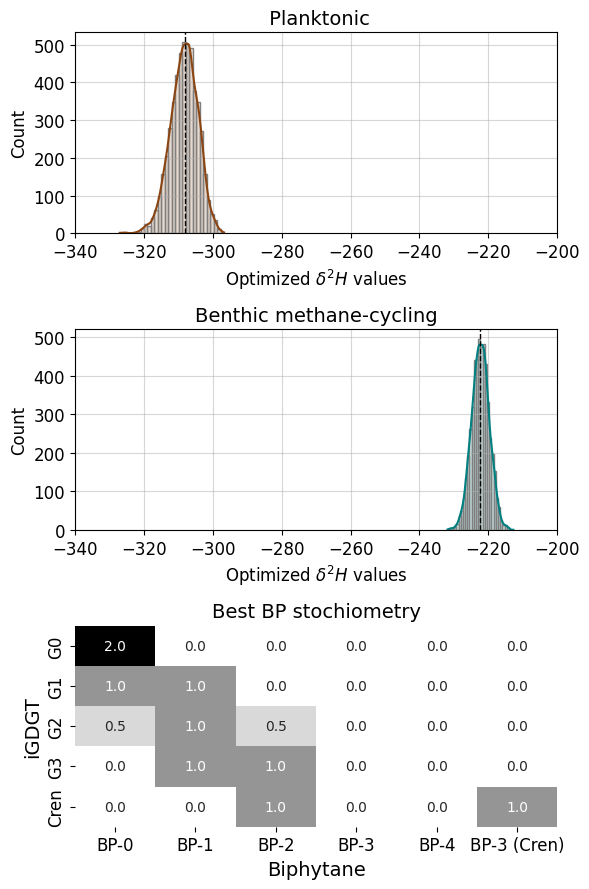

In [53]:

#remove iGDGT-4 for clarity
best_combination = np.array([
    [2, 0, 0, 0, 0, 0],     # GDGT-0
    [1, 1, 0, 0, 0, 0],     # GDGT-1
    [0.5, 1, 0.5, 0, 0, 0], # GDGT-2
    [0, 1, 1, 0, 0, 0],     # GDGT-3
    [0, 0, 1, 0, 0, 1]      # Crenarchaeol
])

gdgt_labels = ['G0', 'G1', 'G2', 'G3', 'Cren']
biphytane_labels = ['BP-0', 'BP-1', 'BP-2', 'BP-3', 'BP-4', 'BP-3 (Cren)']

# Create 3 stacked subplots
fig, axes = plt.subplots(3, 1, figsize=(6, 9), sharex=False)

# First histogram (Planktonic BP-0)
sns.histplot(bootstrap_results[:, 1], 
             color='saddlebrown', edgecolor='grey', alpha=0.2, bins=30, kde=True, ax=axes[0])
axes[0].axvline(best_params[1], color='k', linestyle='--', linewidth=1)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title(' Planktonic', fontsize=14)
axes[0].set_xlim([-340,-200])
axes[0].grid('on', alpha = 0.5)
axes[0].set_xlabel('Optimized $\\delta^{2}H$ values', fontsize=12)
axes[1].set_xlabel('Optimized $\\delta^{2}H$ values', fontsize=12)

# Second histogram (Methane BP-0)
sns.histplot(bootstrap_results[:, 0], 
             color='teal', alpha=0.2, edgecolor='grey', bins=30, kde=True, ax=axes[1])
axes[1].axvline(best_params[0], color='k', linestyle='--', linewidth=1)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Benthic methane-cycling', fontsize=14)
axes[1].set_xlim([-340,-200])
axes[1].grid('on', alpha = 0.5)

# Third subplot: Heatmap
sns.heatmap(
    best_combination, 
    annot=True, 
    cmap='Greys', 
    xticklabels=biphytane_labels, 
    yticklabels=gdgt_labels, 
    cbar=False,
    fmt='.1f',
    ax=axes[2]
)
axes[2].set_title('Best BP stochiometry', fontsize=14)
axes[2].set_xlabel('Biphytane', fontsize=14)
axes[2].set_ylabel('iGDGT', fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=12) 
axes[0].tick_params(axis='both', which='major', labelsize=12) 
axes[1].tick_params(axis='both', which='major', labelsize=12) 

# Adjust layout and display
plt.tight_layout()
plt.savefig('../Figures/stacked_subplots.png', dpi=300, bbox_inches='tight')
plt.show()

## Model Performance

In [25]:
pred_df = df_with_predictions
# Define the custom order for biphytanes
biphytane_order = ['BP-0', 'BP-1', 'BP-2', 'BP-3 (Cren)']

# Set the 'biphytane' column as a categorical type with the custom order
pred_df['biphytane'] = pd.Categorical(pred_df['biphytane'], categories=biphytane_order, ordered=True)

# Sort the DataFrame by the custom biphytane order
pred_df_sorted = pred_df.sort_values(by='biphytane')

In [26]:
pred_df_sorted['residual'] = pred_df_sorted['d2H_calculated'] - pred_df_sorted['corrected_d2H.permil']

# Calculate residuals
residuals = pred_df_sorted['corrected_d2H.permil'] - pred_df_sorted['d2H_calculated']

# Calculate MAE
mae = np.mean(np.abs(residuals))
print(f'The MAE is {np.round(mae,1)}')

The MAE is 11.4


<>:45: SyntaxWarning: invalid escape sequence '\d'
<>:45: SyntaxWarning: invalid escape sequence '\d'
/var/folders/13/217c9md10ldcbnl1vbd8_hnr0000gn/T/ipykernel_34327/2944499079.py:45: SyntaxWarning: invalid escape sequence '\d'
  ax[1].set_ylabel('$\delta^{2}H$ residuals (‰)', fontsize =14)


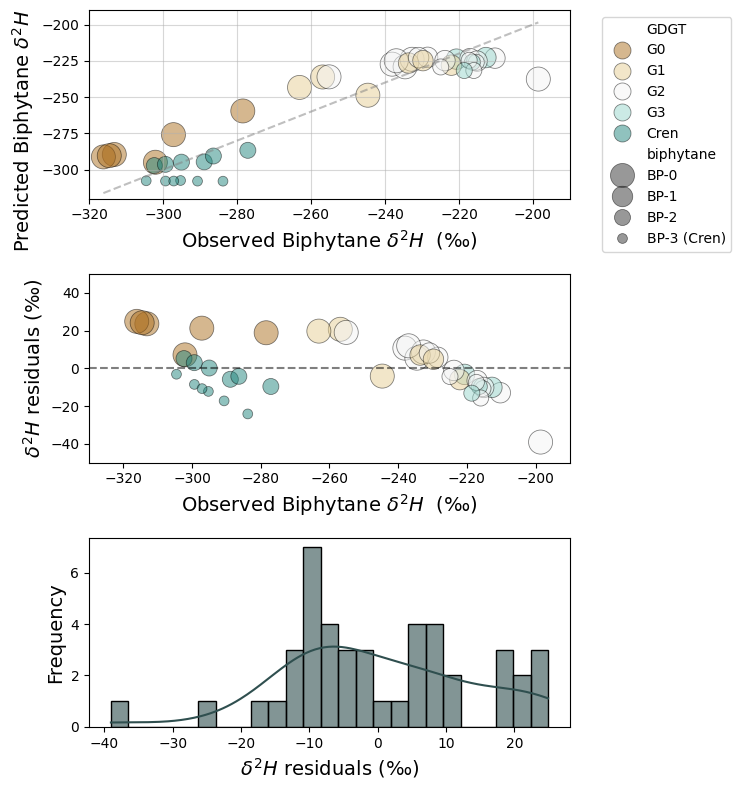

In [27]:
fig, ax = plt.subplots(3,1, figsize = (8,8))
bp_markers = {
    'BP-0': 'o',
    'BP-1': '^',
    'BP-2': 's',
    'BP-3 (Cren)': 'P',
    'BP-4': '*'
}


sns.scatterplot(data =pred_df_sorted, x = 'corrected_d2H.permil', y = 'd2H_calculated', sizes =(50,300),
alpha =0.5,
palette='BrBG',
s =150,
edgecolor = 'k',
hue = 'GDGT' ,
legend = True,
size ='biphytane',
ax = ax[0])
# Plot the 1:1 straight line
min_val = min(pred_df['corrected_d2H.permil'].min(), pred_df['d2H_calculated'].min())
max_val = max(pred_df['corrected_d2H.permil'].max(), pred_df['d2H_calculated'].max())
ax[0].plot([min_val, max_val], [min_val, max_val], linestyle='--', color='grey', alpha = 0.5)
ax[0].set_xlim([-320,-190])
ax[0].set_ylim([-320,-190])
ax[0].grid('on',alpha = 0.5)
ax[0].set_ylabel('Predicted Biphytane $\\delta^{2}H$  (‰)', fontsize =14)
ax[0].set_xlabel('Observed Biphytane $\\delta^{2}H$  (‰)', fontsize =14)
ax[0].legend(bbox_to_anchor=(1.35,1), loc = 'upper right')


sns.scatterplot(data =pred_df_sorted, x = 'corrected_d2H.permil', y = 'residual', sizes= (50,300),
alpha =0.5,
palette='BrBG',
s =150,
edgecolor = 'k',
hue = 'GDGT' ,
legend = False,
size ='biphytane',
ax=ax[1])
ax[1].axhline(y=0, color = 'k', linestyle = '--', alpha  =0.5)
ax[1].set_ylim([-50,50])
ax[1].set_xlim([-330,-190])
ax[1].set_xlabel('Observed Biphytane $\\delta^{2}H$  (‰)', fontsize =14)
ax[1].set_ylabel('$\delta^{2}H$ residuals (‰)', fontsize =14)


sns.histplot(data = pred_df_sorted, x = 'residual', bins = 25,
kde = True, 
ax = ax[2],
color = 'darkslategrey',
alpha = 0.6)
ax[2].set_xlabel('$\\delta^{2}H$ residuals (‰)', fontsize =14)
ax[2].set_ylabel('Frequency', fontsize=14) 
plt.tight_layout()

# plt.tight_layout()
plt.savefig('../Figures/model_performance.png',bbox_inches = 'tight', dpi =400)

In [189]:
pred_df_sorted

,sample_id,biphytane,distance_from_plume,corrected_d2H.permil,corrected_d2H_sem.permil,d13C,sample,GDGT,F_plank,d2H_calculated,residual
46,S5_G0,BP-0,20,-278.438865,3.959855,-63.31,S5,G0,0.439114,-259.578234,18.860631
25,S11_G1,BP-0,0,-256.857665,4.096167,-85.06,S11,G1,0.163797,-236.151426,20.706239
24,S11_G0,BP-0,0,-313.170713,3.959855,-35.78,S11,G0,0.787595,-289.597201,23.573512
61,S9_G0,BP-0,0,-316.126675,3.959855,-34.27,S9,G0,0.806709,-291.255718,24.870957
49,S5_G2,BP-0,20,-238.059067,4.719030,-93.32,S5,G2,0.059241,-227.320646,10.738421
17,S10_G2,BP-0,0,-234.560903,4.313792,-91.61,S10,G2,0.080886,-229.145847,5.415056
14,S10_G1,BP-0,0,-263.098011,4.096167,-78.34,S10,G1,0.248861,-243.362501,19.735510
28,S11_G2,BP-0,0,-232.676339,4.096167,-96.46,S11,G2,0.019494,-223.973122,8.703217
62,S9_G2,BP-0,0,-236.950222,3.959855,-95.52,S9,G2,0.031392,-224.974702,11.975521
47,S5_G1,BP-0,20,-244.633337,4.719030,-73.35,S5,G1,0.312025,-248.732736,-4.099399


In [ ]:
calculate_d2H_v2